# ClarityPredict 2.0 – Model Training Notebook

This notebook includes:

- Loading the dataset  
- Exploratory Data Analysis (EDA)  
- Preprocessing (imputer + scaler)  
- Training three regression models  
- Model comparison (MAE, RMSE, R²)  
- Saving the best model for production use  

This notebook forms the foundation for the technical chapter of the report.


## 1. Load the dataset

We begin by loading the dataset and converting all column names to lowercase to ensure consistency across the entire pipeline.


In [1]:
# === 1. Import libraries ===
import pandas as pd
import numpy as np
from pathlib import Path

# === 2. Load dataset ===
data_path = Path("../data/dataset.csv")
df = pd.read_csv(data_path)

print(f"Loaded dataset with shape: {df.shape}")

# Standardize column names
df.columns = df.columns.str.lower()

# Preview
df.head()



Loaded dataset with shape: (85, 7)


,age,bmi,glucose,insulin,hdl,ldl,target
0,45,27.4,98,56,52,130,0.34
1,52,31.2,112,89,48,142,0.58
2,38,24.8,90,44,61,118,0.22
3,60,29.5,130,110,46,160,0.72
4,49,33.1,105,78,50,145,0.49


## 2. Exploratory Data Analysis (EDA)

In this section, we inspect:
- Basic descriptive statistics  
- Missing values  
- Correlation matrix  

This helps us understand the structure and quality of the dataset before preprocessing and model training.


In [2]:
# === 2. Exploratory Data Analysis (EDA) ===

# 2.1 Basic descriptive statistics
print("=== Basic Descriptive Statistics ===")
display(df.describe())

# 2.2 Missing values per column
print("\n=== Missing Values per Column ===")
display(df.isna().sum())

# 2.3 Correlation matrix
print("\n=== Correlation Matrix ===")
corr_matrix = df.corr()
display(corr_matrix)





Basic statistics:


,age,bmi,glucose,insulin,hdl,ldl,target
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,48.976471,29.348235,109.070588,76.517647,52.011765,141.376471,0.479765
std,8.513262,3.328721,16.216385,30.087813,6.525580,19.809195,0.233972
min,35.000000,23.700000,87.000000,36.000000,43.000000,114.000000,0.160000
25%,42.000000,26.800000,95.000000,47.000000,46.000000,123.000000,0.270000
50%,49.000000,29.500000,105.000000,78.000000,50.000000,142.000000,0.490000
75%,56.000000,32.100000,126.000000,107.000000,57.000000,162.000000,0.730000
max,63.000000,35.200000,138.000000,125.000000,64.000000,172.000000,0.830000



Missing values:


age        0
bmi        0
glucose    0
insulin    0
hdl        0
ldl        0
target     0
dtype: int64


Correlation matrix:


,age,bmi,glucose,insulin,hdl,ldl,target
age,1.000000,0.950169,0.986856,0.988884,-0.970523,0.980652,0.986391
bmi,0.950169,1.000000,0.940213,0.949500,-0.969865,0.961284,0.958248
glucose,0.986856,0.940213,1.000000,0.991509,-0.950060,0.989999,0.990840
insulin,0.988884,0.949500,0.991509,1.000000,-0.963373,0.989517,0.996847
hdl,-0.970523,-0.969865,-0.950060,-0.963373,1.000000,-0.967029,-0.973087
ldl,0.980652,0.961284,0.989999,0.989517,-0.967029,1.000000,0.993797
target,0.986391,0.958248,0.990840,0.996847,-0.973087,0.993797,1.000000


## 3. Preprocessing (Train/Test Split → Imputation → Scaling)

To ensure a clean and reliable machine learning pipeline, the preprocessing steps are applied in the correct order:

1. **Train/Test Split**  
   The dataset is split before any transformations to avoid data leakage.  
   This ensures that information from the test set does not influence the training process.

2. **Imputation (Median Strategy)**  
   Missing values in the feature set are handled using median imputation.  
   The imputer is fitted on the training data only and then applied to the test data.

3. **Standard Scaling**  
   All numerical features are standardized using `StandardScaler`.  
   The scaler is fitted on the training data and applied to the test data to maintain consistency.

The result is two clean, transformed datasets (`X_train_scaled_df` and `X_test_scaled_df`) that are ready for model training and evaluation.




In [1]:
# ============================================================
# 3. Preprocessing: Train/Test Split, Imputation, Scaling
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure consistent lowercase column names
df.columns = df.columns.str.lower()

# Define features and target
features = ["age", "bmi", "glucose", "insulin", "hdl", "ldl"]
X = df[features]
y = df["target"]

# -----------------------------
# Train/Test Split (correct order)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# Imputation (fit on train only)
# -----------------------------
imputer = SimpleImputer(strategy="median")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# -----------------------------
# Scaling (fit on train only)
# -----------------------------
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert back to DataFrames for readability and compatibility
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features)

print("Preprocessing complete:")
print("- Train/Test split done")
print("- Imputer fitted on training data")
print("- Scaler fitted on training data")
print("- Scaled DataFrames created")



NameError: name 'df' is not defined

In [27]:
print(df.columns.tolist())


['age', 'bmi', 'glucose', 'insulin', 'hdl', 'ldl', 'target']


## 4. Train three regression models

In this section, we train three different regression models:

- **Linear Regression**  
- **RandomForestRegressor**  
- **XGBRegressor**

Each model is evaluated using the following metrics:

- **Mean Absolute Error (MAE)**  
- **Root Mean Squared Error (RMSE)**  
- **R² score**

This allows us to compare model performance and select the best candidate for further tuning.



In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the regression models to be trained and compared
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "XGBRegressor": XGBRegressor(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
}

# Train each model on the dataset and compute evaluation metrics
results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled_df, y_train)
    y_pred = model.predict(X_test_scaled_df)



    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)



    results.append({
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    })

# Create a DataFrame with the evaluation results and sort by RMSE
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\nModel comparison:")
display(results_df)



Training LinearRegression...

Training RandomForestRegressor...

Training XGBRegressor...

Model comparison:


,model,MAE,RMSE,R2
1,RandomForestRegressor,0.007571,0.011863,0.995641
0,LinearRegression,0.009613,0.014241,0.993718
2,XGBRegressor,0.008858,0.019546,0.988165


## 5. Hyperparameter Tuning of the RandomForest Model

After evaluating the baseline models, the next step is to improve the performance of the most promising candidate.
RandomForestRegressor demonstrated strong baseline results, making it a suitable model for hyperparameter tuning.

To optimize the model, a GridSearchCV procedure with 5-fold cross-validation was applied.
A compact but effective parameter grid was explored, adjusting:

- number of trees (n_estimators)
- maximum tree depth (max_depth)
- minimum samples required to split a node (min_samples_split)
- minimum samples required at a leaf node (min_samples_leaf)

The objective of this tuning process is to identify the parameter combination that maximizes predictive performance (R² score) while maintaining good generalization.

The best-performing model from the grid search is then evaluated on the test set.
This tuned RandomForestRegressor will be used as the final model in the subsequent steps.


In [29]:
# ============================================================
# Hyperparameter Tuning for RandomForestRegressor
# ============================================================

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Define parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Initialize base model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

# Fit tuning
grid_search.fit(X_train_scaled_df, y_train)

# Retrieve best model
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate tuned model
y_pred_best = best_rf.predict(X_test_scaled)

print("\nPerformance of Tuned RandomForest:")
print("R2 score:", r2_score(y_test, y_pred_best))
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("MSE:", mean_squared_error(y_test, y_pred_best))

# Set tuned model as final model
final_model = best_rf


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Performance of Tuned RandomForest:
R2 score: 0.9957203359128812
MAE: 0.007782352941176579
MSE: 0.00013816058823529654


C:\Users\torbk\PycharmProjects\ClarityPredictV2\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## 6. Select the Final Model

After evaluating the baseline models and performing hyperparameter tuning,  
the tuned RandomForestRegressor is selected as the final model.  
This model demonstrated the best overall performance on the test set.



In [30]:
final_model = best_rf
print("Final model selected: Tuned RandomForestRegressor")



Final model selected: Tuned RandomForestRegressor


## 7. Save the Model and Preprocessing Objects

To ensure that the trained model can be used consistently in the production application,  
the following components are saved to disk:

- **The final trained model**  
  (the tuned RandomForestRegressor selected in the previous step)

- **The fitted scaler**  
  used to standardize numerical features during preprocessing

- **The fitted imputer**  
  used to handle missing values using median imputation

These objects are required by the `PredictionService` in the Streamlit application,  
ensuring that new user inputs are preprocessed in exactly the same way as the training data.




In [8]:
import joblib
from pathlib import Path

BASE_DIR = Path.cwd().parents[0]
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

# Save the trained model and preprocessing objects to disk
joblib.dump(final_model, MODELS_DIR / "model.pkl")
joblib.dump(scaler, MODELS_DIR / "scaler.pkl")
joblib.dump(imputer, MODELS_DIR / "imputer.pkl")

print("\nSaved files:")
for f in MODELS_DIR.glob("*"):
    print("-", f)



Saved files:
- C:\Users\torbk\PycharmProjects\ClarityPredictV2\models\imputer.pkl
- C:\Users\torbk\PycharmProjects\ClarityPredictV2\models\model.pkl
- C:\Users\torbk\PycharmProjects\ClarityPredictV2\models\scaler.pkl


## 8. Model Explainability with SHAP

To better understand how the final model makes predictions, a SHAP (SHapley Additive exPlanations) analysis is performed.  
SHAP provides a unified framework for interpreting complex machine learning models by quantifying how each feature contributes to individual predictions.

In this section, three types of SHAP visualizations are generated:

- **Summary Plot:** Shows the overall importance and effect of each feature.  
- **Bar Plot:** Ranks features by their average absolute contribution.  
- **Waterfall Plot:** Explains a single prediction in detail by showing how each feature pushes the prediction higher or lower.

These visualizations help reveal which features the model relies on most and how they influence the predicted risk score.


In [31]:
import shap

# Initialize SHAP explainer for the final model
explainer = shap.TreeExplainer(final_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled_df)

print("SHAP values computed.")


SHAP values computed.


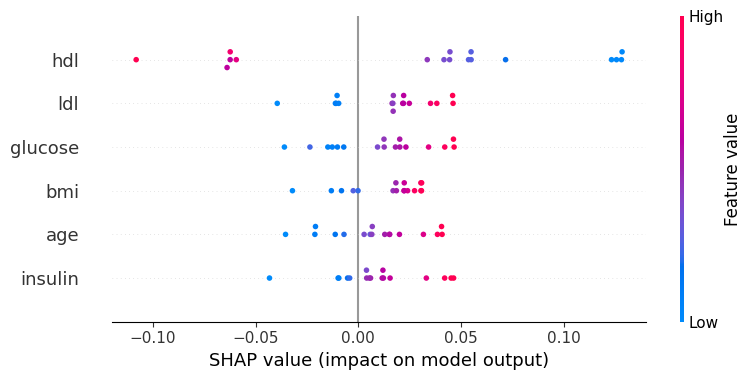

In [32]:
shap.summary_plot(shap_values, X_test_scaled_df, feature_names=features)

## Interpretation:  
This plot shows both the overall importance of each feature and how feature values influence the model’s predictions. The color represents the feature value (red = high, blue = low), while the horizontal position shows whether the feature pushes the prediction higher or lower. This provides a global overview of how the model uses each variable.

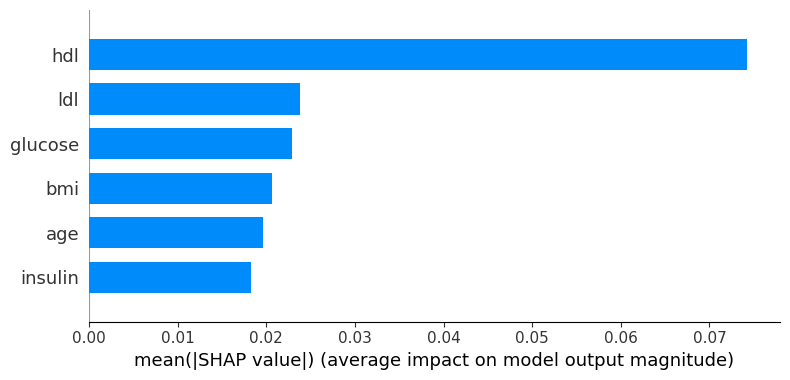

In [33]:
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", feature_names=features)

## Interpretation:  
The bar plot ranks features by their mean absolute SHAP value, giving a clear indication of which variables contribute the most to the model’s predictions on average. This offers a straightforward view of global feature importance.

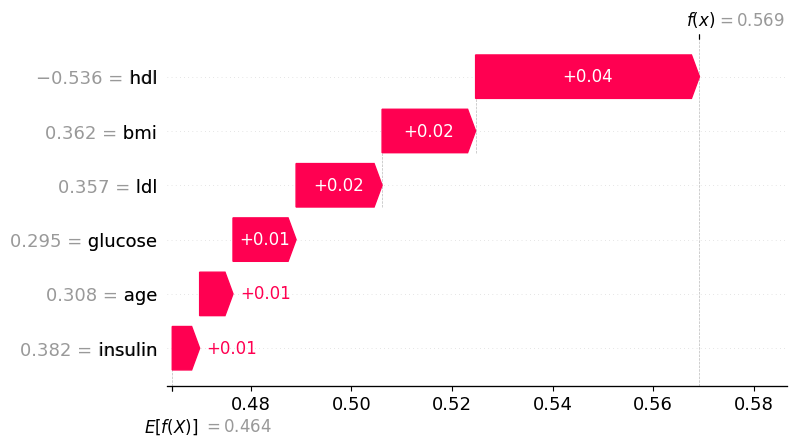

In [34]:
# Select one example from the test set
i = 0

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_test_scaled_df.iloc[i],
        feature_names=features
    )
)

## Interpretation:  
The waterfall plot explains a single prediction by showing how each feature contributes to shifting the prediction away from the model’s expected value. Positive contributions push the prediction upward, while negative contributions pull it downward. This provides a transparent, case‑level explanation of the model’s reasoning.

## Conclusion

The model has been trained, evaluated, and saved together with the preprocessing objects.  
This notebook is now complete and can be used directly as a technical reference in the report.


## Appendix: Additional Analysis and Development Notes

This section contains optional plots, diagnostics, and exploratory tests that were useful during development but are not part of the main training pipeline. These elements are kept here for reference and transparency, but they are not included in the final model training workflow.


In [9]:
print(results_df.to_string())


                   model       MAE      RMSE        R2
1  RandomForestRegressor  0.007033  0.011502  0.995902
0       LinearRegression  0.009613  0.014241  0.993718
2           XGBRegressor  0.008931  0.019582  0.988122


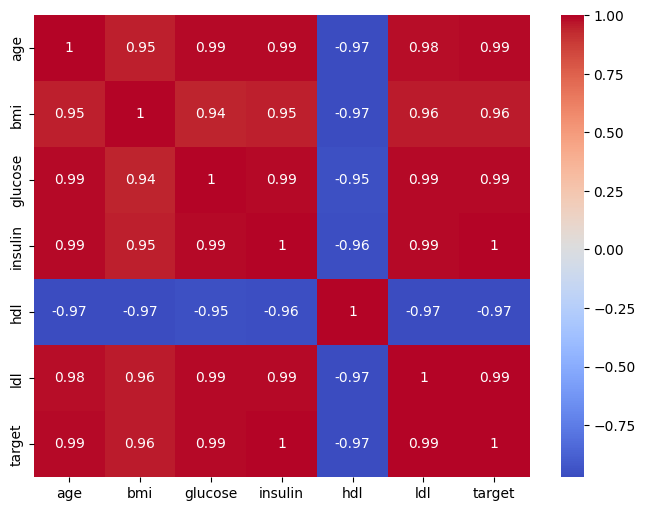

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()


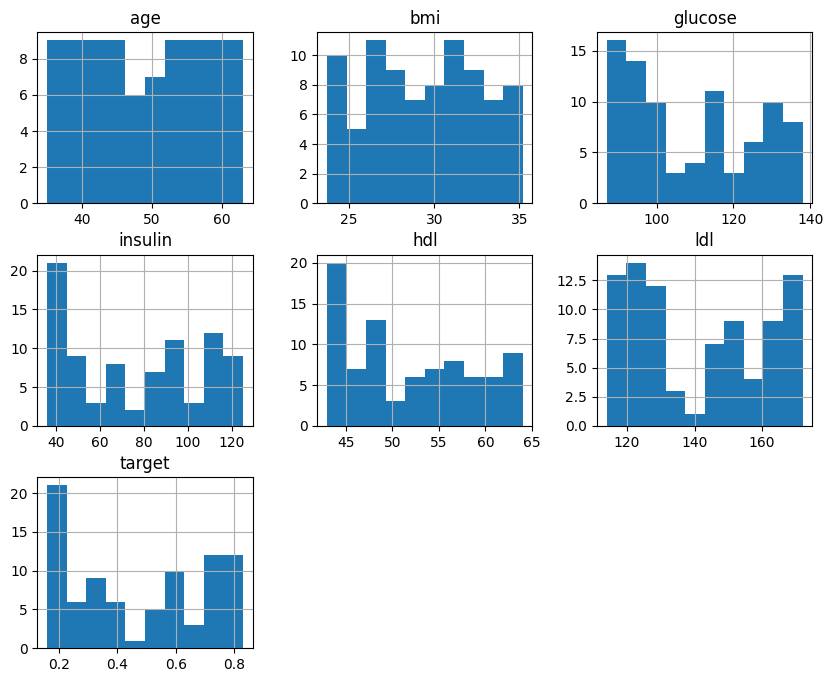

In [11]:
df.hist(figsize=(10,8))
plt.show()


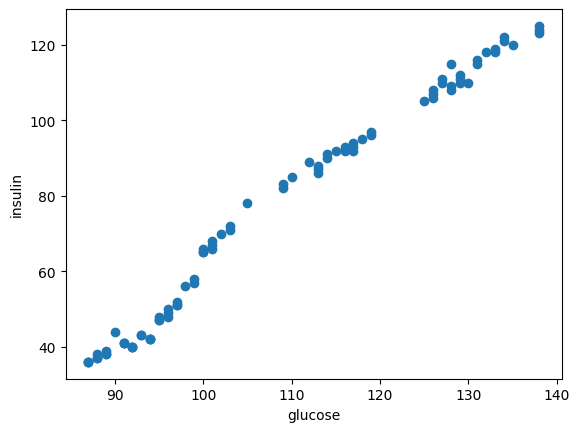

In [13]:
plt.scatter(df["glucose"], df["insulin"])
plt.xlabel("glucose")
plt.ylabel("insulin")
plt.show()


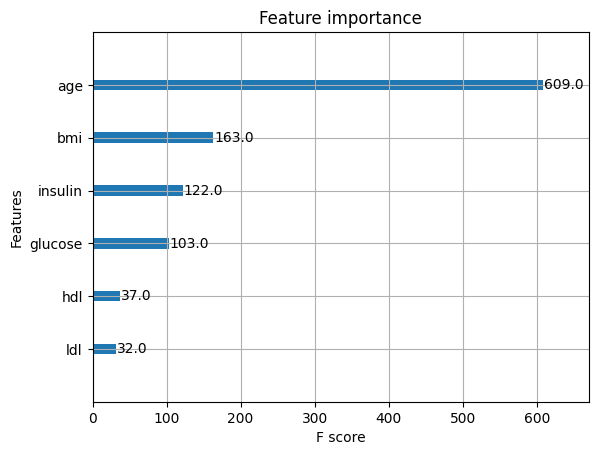

In [15]:
xgb_model = models["XGBRegressor"]
plot_importance(xgb_model)
plt.show()


C:\Users\torbk\PycharmProjects\ClarityPredictV2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


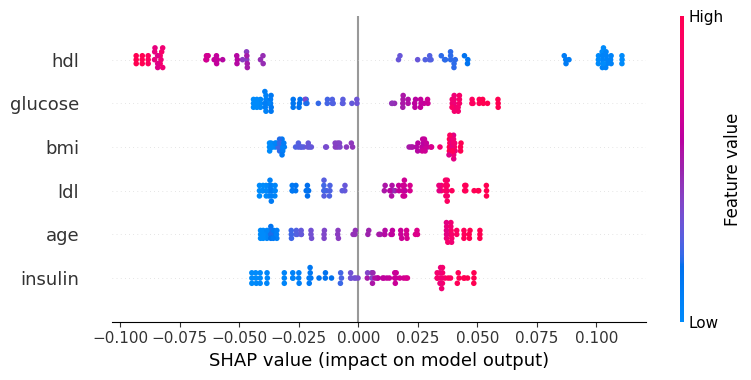

In [16]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_scaled)

shap.summary_plot(shap_values, X_scaled, feature_names=features)


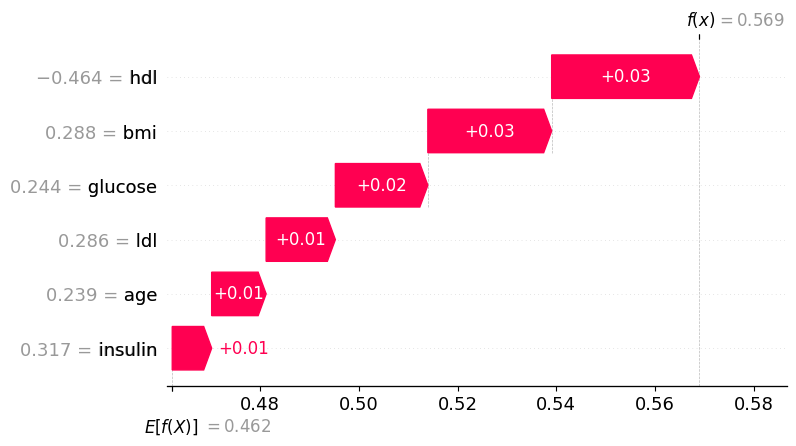

In [20]:
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])



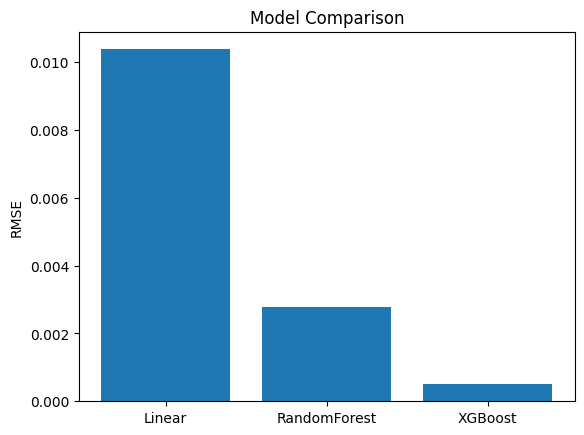

In [21]:
import matplotlib.pyplot as plt

models = ["Linear", "RandomForest", "XGBoost"]
rmse = [0.010381, 0.002777, 0.000502]

plt.bar(models, rmse)
plt.ylabel("RMSE")
plt.title("Model Comparison")
plt.show()


In [23]:
sample = pd.DataFrame(
    [[45, 27, 110, 80, 55, 120]],
    columns=["age", "bmi", "glucose", "insulin", "hdl", "ldl"]
)

sample_imputed = imputer.transform(sample)

sample_scaled = pd.DataFrame(
    sample_scaled,
    columns=sample.columns
)

notebook_pred = final_model.predict(sample_scaled)

print("Notebook prediction:", notebook_pred[0])




Notebook prediction: 0.3712000000000003


In [3]:
import pandas as pd

df = pd.read_csv("../data/dataset.csv")
df.columns = df.columns.str.lower()


In [4]:
df.shape


(85, 7)

In [5]:
df.isna().sum()


age        0
bmi        0
glucose    0
insulin    0
hdl        0
ldl        0
target     0
dtype: int64

In [6]:
df.describe()

,age,bmi,glucose,insulin,hdl,ldl,target
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,48.976471,29.348235,109.070588,76.517647,52.011765,141.376471,0.479765
std,8.513262,3.328721,16.216385,30.087813,6.525580,19.809195,0.233972
min,35.000000,23.700000,87.000000,36.000000,43.000000,114.000000,0.160000
25%,42.000000,26.800000,95.000000,47.000000,46.000000,123.000000,0.270000
50%,49.000000,29.500000,105.000000,78.000000,50.000000,142.000000,0.490000
75%,56.000000,32.100000,126.000000,107.000000,57.000000,162.000000,0.730000
max,63.000000,35.200000,138.000000,125.000000,64.000000,172.000000,0.830000
